# Denoising Posterior Comparison

In [1]:
%matplotlib inline
from model import *
import torch
import seaborn as sns
from utils import *
from mmd import *
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## True posterior 

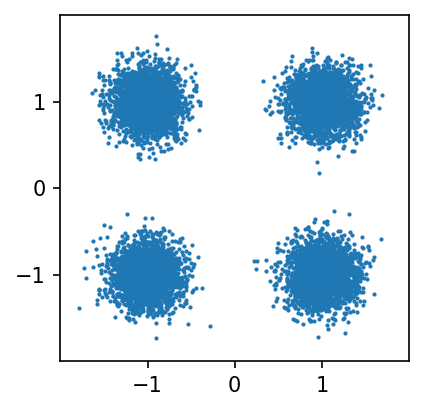

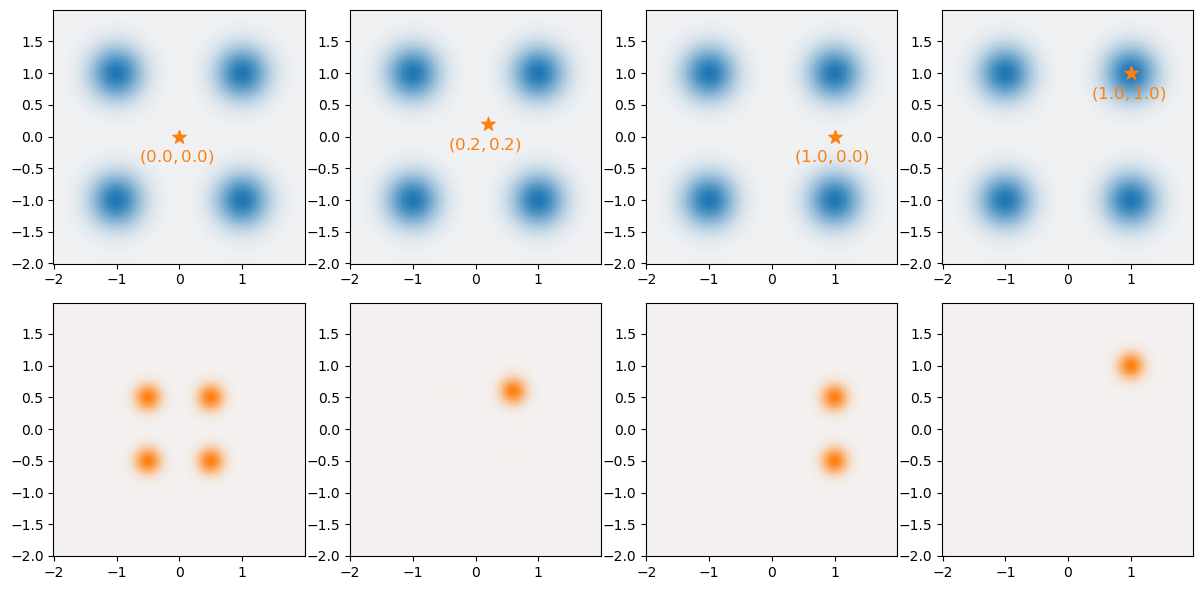

In [2]:
palette = sns.color_palette()

gmm_std=0.2
gmm=MoG4(std=gmm_std)

noise_std=0.2
t_gmm_std=np.sqrt((noise_std**2+gmm_std**2))
t_gmm=MoG4(std=t_gmm_std)


def log_ptx_x(tx,x):
    return Normal(x,torch.ones_like(x)*noise_std).log_prob(tx).sum(-1)

def log_px_tx(x,tx):
    return log_ptx_x(tx,x)+gmm.log_prob(x)-t_gmm.log_prob(tx)

X,Y=get_mesh()
p_true_data=mesh_to_density(X,Y,lambda x:torch.exp(gmm.log_prob(x)))
p_noisy_data=mesh_to_density(X,Y,lambda x:torch.exp(t_gmm.log_prob(x)))


test_points=[torch.tensor([0.,0.]), torch.tensor([0.2,0.2]), torch.tensor([1.,0.]), torch.tensor([1.,1.])]
p_true_list=[mesh_to_density(X,Y,lambda x:torch.exp(log_px_tx(x,tx))) for tx in test_points]

dataset=torch.Tensor(gmm.sample([10000])).float()
get_plt()
plt.scatter(*dataset.T, alpha=1., color=palette[0], s=1);


def plot_pos(x, p, num=1, ax1=None, ax2=None):
    ax1.pcolormesh(X, Y, p_noisy_data.reshape(X.shape[0],Y.shape[0]), alpha=1.0,cmap=sns.light_palette(palette[0],as_cmap=True))
    ax1.scatter(x[0],x[1],marker='*',color=palette[1],s=100)
    ax1.text(x[0]-0.64, x[1]-0.4, r'$('+str(x[0])+','+str(x[1])+')$', fontdict=get_font(palette[1]))
    ax2.pcolormesh(X, Y, p.reshape(X.shape[0],Y.shape[0]), alpha=1.0,cmap=sns.light_palette(palette[1],as_cmap=True))

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for num, point in enumerate(test_points):
    plot_pos(point.numpy(), p_true_list[num].numpy(),num+1, ax1=axes[0, num], ax2=axes[1, num])
plt.tight_layout()
plt.show()

# 1. Learning the mean and the vairance by KL minimization

100%|█████████████████████████████████████████| 100/100 [00:16<00:00,  6.10it/s]


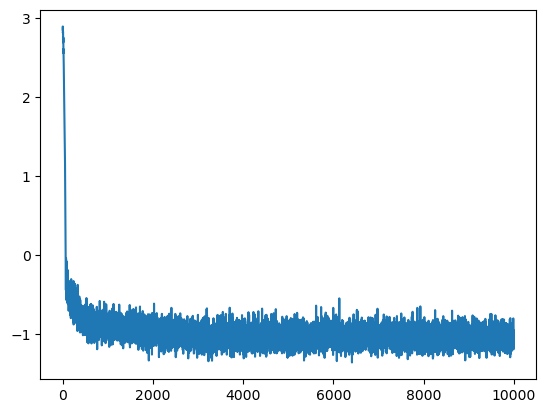

In [3]:
opt={
    'epochs':100,
    'batch_size':100,
    'test_batch_size':100,
    'gibbs_steps':10000,
    'device':'cuda:0',
    'noise_std':0.2,
    'x_dim':2,
    'layer_num':3,
    'lr':1e-4,
    'act':'swish',
    'seed':0,
}

np.random.seed(opt['seed'])
torch.manual_seed(opt['seed'])

model1=DenoiserLearnedVar(opt)
loss_list=[]

model1.train()
iterations=int(dataset.size()[0]/opt['batch_size'])
for t in tqdm(range(0,opt['epochs'])):
    for _ in range(0,iterations):
        model1.optimizer.zero_grad()
        batch_x = dataset[np.random.choice(dataset.size()[0],opt['batch_size'])].to(opt['device'])
        noisy_x=(batch_x+torch.randn_like(batch_x)*opt['noise_std'])
        loss=-model1.logp_x_tx(batch_x,noisy_x).mean(0)
        loss.backward()
        model1.optimizer.step()
            
        loss_list.append(loss.item())
plt.plot(loss_list)
plt.show()

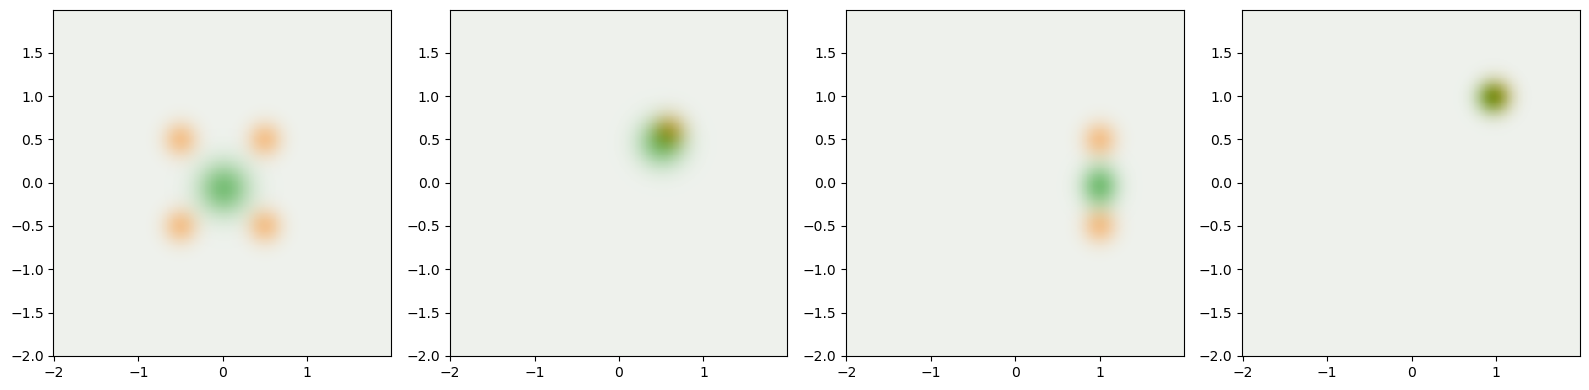

In [4]:
with torch.no_grad():
    p_learned_var_list=[mesh_to_density(X,Y,lambda x:torch.exp(model1.logp_x_tx(x,point))) for point in test_points ]
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for ax, p_true, p_learned in zip(axes, p_true_list, p_learned_var_list):
    compare(X, Y, p_true, p_learned, ax)

plt.tight_layout()
plt.show()

In [5]:
np.random.seed(opt['seed'])
torch.manual_seed(opt['seed'])

mmd_loss=MMD_loss(kernel_num=5)
mmd_list=[]

x_init=torch.randn(1,2)*0.1+1
for _ in range(0,5):
    model1_samples=gibbs_sampler(x_init, model1.sample, opt)
    mmd=mmd_loss.forward(source=dataset[0:opt['gibbs_steps']], target=model1_samples.cpu())
    mmd_list.append(mmd.item())

print(np.mean(mmd_list),np.std(mmd_list))

100%|███████████████████████████████████| 10000/10000 [00:03<00:00, 2631.42it/s]


0.9290302157402038 0.3436728113591784


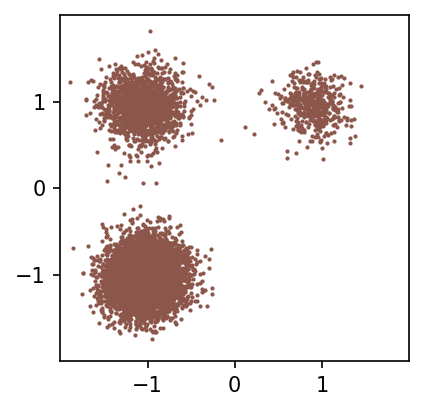

In [6]:
get_plt()
plt.scatter(model1_samples[:,0],model1_samples[:,1], alpha=1., color=palette[5], s=1)
plt.show()

# Denoising score matching to learn the mean

100%|█████████████████████████████████████████| 100/100 [00:16<00:00,  5.96it/s]


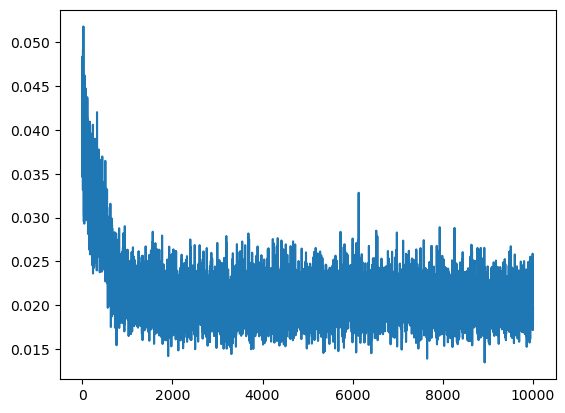

In [7]:
np.random.seed(opt['seed'])
torch.manual_seed(opt['seed'])

model2=DenoisingEBM(opt)
loss_list=[]
model2.train()
iterations=int(dataset.size()[0]/opt['batch_size'])
for t in tqdm(range(0,opt['epochs'])):
    for _ in range(0,iterations):
        model2.optimizer.zero_grad()
        indices = np.random.choice(dataset.size()[0],opt['batch_size'])
        batch_x = dataset[indices].to(opt['device'])
        noisy_x=(batch_x+torch.randn_like(batch_x)*opt['noise_std'])
        denoised_x_mean=model2(noisy_x)
        loss= torch.mean((batch_x-denoised_x_mean)**2)
        loss.backward()
        model2.optimizer.step()
        loss_list.append(loss.item())
plt.plot(loss_list)
plt.show()


# 2. $\tilde{x}$-independent isotropic moment matching

Estimated isotropic variance: 0.018718115985393524


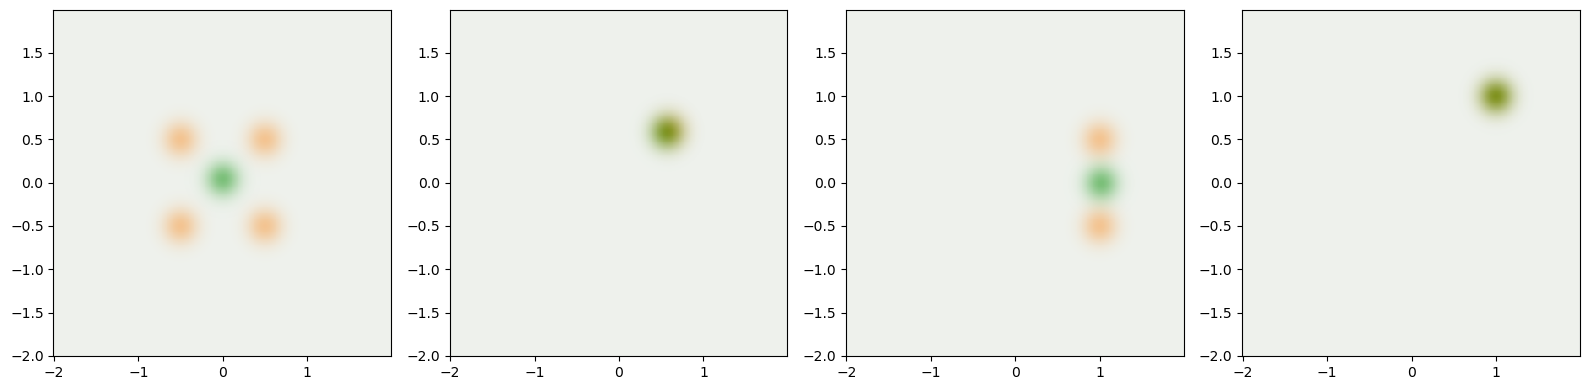

In [8]:
### estimate the isotropic variance
print('Estimated isotropic variance:', model2.isotropic_cov_estimation(dataset).item())

p_iso_cov_list=[mesh_to_density(X,Y,lambda x:torch.exp(model2.logp_x_tx_isotropic_cov(x,point))) for point in test_points]
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for ax, p_true, p_iso_cov in zip(axes, p_true_list, p_iso_cov_list):
    compare(X, Y, p_true, p_iso_cov, ax)

plt.tight_layout()
plt.show()

In [9]:
np.random.seed(opt['seed'])
torch.manual_seed(opt['seed'])

mmd_loss=MMD_loss(kernel_num=5)
mmd_list=[]
x_init=torch.randn(1,2)*0.1+1
for _ in range(0,5):
    model2_samples=gibbs_sampler(x_init, model2.sample_isotropic_cov, opt)
    mmd=mmd_loss.forward(source=dataset[0:opt['gibbs_steps']], target=model2_samples.cpu())
    mmd_list.append(mmd.item())

print(np.mean(mmd_list),np.std(mmd_list))

100%|████████████████████████████████████| 10000/10000 [00:12<00:00, 784.70it/s]


0.7244957625865937 0.361139565054703


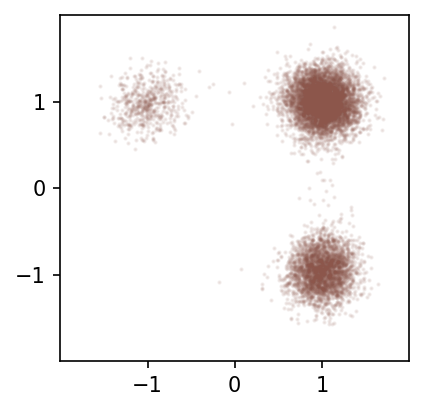

In [10]:
get_plt()
plt.scatter(model1_samples[:,0],model1_samples[:,1], alpha=.1, color=palette[5], s=1)
plt.show()

# 3. The proposed $\tilde{x}$-dependent full moment matching

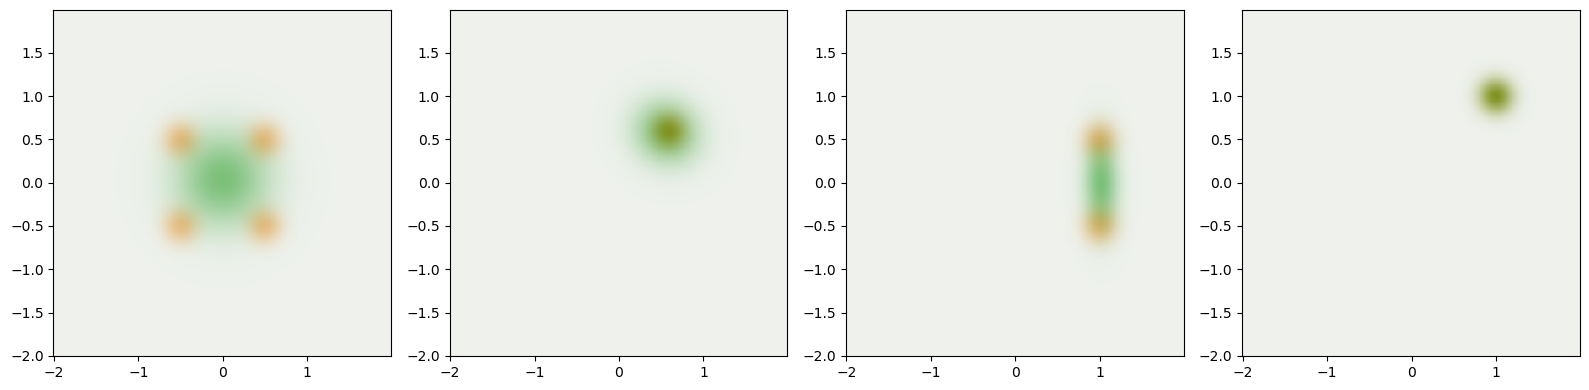

In [11]:
p_full_cov_list=[mesh_to_density(X,Y,lambda x:torch.exp(model2.logp_x_tx_full_cov(x,point))) for point in test_points]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for ax, p_true, p_full_cov in zip(axes, p_true_list, p_full_cov_list):
    compare(X, Y, p_true, p_full_cov, ax)

plt.tight_layout()
plt.show()

In [12]:
np.random.seed(opt['seed'])
torch.manual_seed(opt['seed'])

mmd_loss=MMD_loss(kernel_num=5)
mmd_list=[]
x_init=torch.randn(1,2)*0.1+1
for _ in range(0,5):
    model2_samples=gibbs_sampler(x_init, model2.sample_full_cov, opt)
    mmd=mmd_loss.forward(source=dataset[0:opt['gibbs_steps']], target=model2_samples.cpu())
    mmd_list.append(mmd.item()) 

print(np.mean(mmd_list),np.std(mmd_list))

100%|████████████████████████████████████| 10000/10000 [00:23<00:00, 417.29it/s]


0.3052608847618103 0.1418217143725759


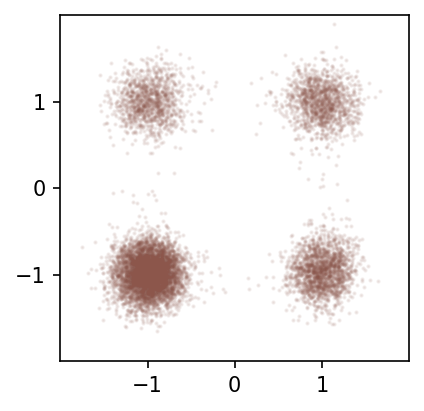

In [13]:
get_plt()
plt.scatter(model1_samples[:,0],model1_samples[:,1], alpha=.1, color=palette[5], s=1)
plt.show()